# Predicting Medicare Spending 

#### Background: 

The egregious level of spending on Healthcare in the United States is a very contentious topic these days. The U.S. government has implemented many measures to try to improve the quality of care while reducing costs. The program I am focusing on is called Hospital Value Based Purchasing in which the government would reward hospitals with incentive payments for the quality of care provided. Hospital Value Based Purchasing calculates the payments that are awarded to hospitals based on 4 different criteria. One of those criteria focuses on the cost effectiveness of a hospital's operations (the other criteria focus more on quality) and this criteria is measured by a metric called Medicare Spending per Beneficiary

#### Target Variable Explination: 
My target is a measure called Medicare Spending per Beneficiary (MSPB) and the score is a risk adjusted average MSPB for the hospital divided by the median MSPB for the nation. Thus a score of 1 is in line with the national median, a score below 1 means that the hospital is spending less on average than the median hospital which is preferred. In essence this is all about effieincy- if spending is less than average it would mean that the hospital is utilizing its resources more efficiently.


IMPORTANT NOTE: This project only focuses on Medicare patients so there could be other relationships that apply for other patients (Medicaid or Commercially-insured patients for example) 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
sns.set_style("darkgrid")
from yellowbrick.regressor import ResidualsPlot

C:\Users\anirudha_nahar\AppData\Local\Continuum\anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Creating our dataset

The data I am using for this project is from a broader set of files called "Hospital Compare", the link is here: https://data.medicare.gov/data/hospital-compare . 

In my initial model my target variable was the Medicare Spending per Beneficiary Score (MSPB). As you will see below, my initial model did not work out too well. 

In [2]:
#reading in the data where my target variable resides
spend_df= pd.read_csv('Medicare Hospital Spending per Patient - Hospital.csv')

#---------------creating my main dataset which I will call spend_df------------------------
#There are quite a few columns in this file but I am just interested in three of them so I am isolating those 
spend_df =spend_df.loc[:,['Provider ID','Hospital Name','Score']]

#missing data is shown as "Not Available" so I am changing that to show as NaN so it is more readable by Pandas 
spend_df['Score']=spend_df['Score'].replace("Not Available",np.nan)

#convert the Medicare Spending per Beneficiary Scores to numeric values as they are originally strings
spend_df['Score']= pd.to_numeric(spend_df['Score'], errors='coerce')

#I only want to work with complete data for this project
spend_df = spend_df.dropna(axis=0, how="any")
spend_df.head()

,Provider ID,Hospital Name,Score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,0.99
1,10005,MARSHALL MEDICAL CENTER SOUTH,1.00
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,1.00
3,10007,MIZELL MEMORIAL HOSPITAL,1.06
4,10008,CRENSHAW COMMUNITY HOSPITAL,0.92


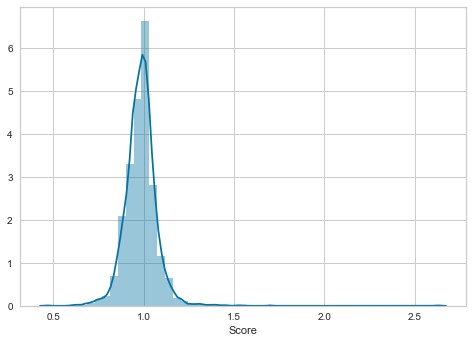

In [3]:
plot_score= pd.Series(spend_df["Score"],name= "MSBP Scores")
sns.distplot(spend_df["Score"])

Out of the original 4806 hospitals in this dataset more than 4000 of them have a score of around 1.0. Something that I learned through a previous iteration of this project is that there could be issues when running your models if your target/ dependent variable has very low variance. Check this link out for more information: https://www.quora.com/How-do-we-reconcile-this-fact-%E2%80%9CThe-mean-squared-error-in-regression-is-close-to-zero-yet-the-R-squared-values-are-much-lower%E2%80%9D


Below are the results of my inital OLS attempt

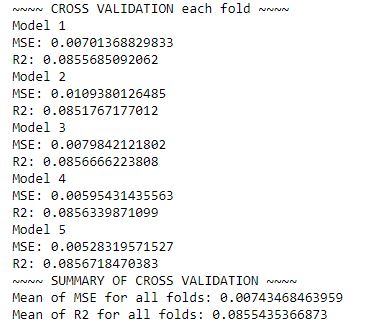

In [4]:
from IPython.core.display import Image
Image ('/Users/anirudha_nahar/Desktop/gitfolder/hospital_2/img/Intial_Results.JPG')

Upon further research into the vast array of information in the Hospital Compare Files I noticed that there is a file which actually breaks down the average level of spending a hospital uses on its Medicare patients rather than a score. In essence I found data that is more "raw" compared to the indexed score which I previously used as my target. I will handle this file below:


In [5]:
claims= pd.read_csv("Medicare Hospital Spending by Claim.csv")
claims= claims.sort_values(by='Provider_ID')
claims.head(15)

,Hospital_Name,Provider_ID,State,Period,Claim_Type,Avg_Spending_Per_Episode_Hospital,Avg_Spending_Per_Episode_State,Avg_Spending_Per_Episode_Nation,Percent_of_Spending_Hospital,Percent_of_Spending_State,Percent_of_Spending_Nation,Start_Date,End_Date
65156,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Home Health Agency,11,13,11,0.05%,0.07%,0.05%,1012016,12312016
30145,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 through 30 days After Discharge from Index H...,Home Health Agency,947,849,697,4.57%,4.44%,3.43%,1012016,12312016
21504,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 through 30 days After Discharge from Index H...,Hospice,147,159,122,0.71%,0.83%,0.60%,1012016,12312016
21503,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,During Index Hospital Admission,Inpatient,9930,9213,9676,47.95%,48.14%,47.66%,1012016,12312016
21502,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Outpatient,171,85,126,0.83%,0.45%,0.62%,1012016,12312016
30146,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 through 30 days After Discharge from Index H...,Durable Medical Equipment,94,105,85,0.46%,0.55%,0.42%,1012016,12312016
34523,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Carrier,497,495,536,2.40%,2.58%,2.64%,1012016,12312016
34524,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 through 30 days After Discharge from Index H...,Outpatient,593,573,697,2.86%,3.00%,3.43%,1012016,12312016
17106,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,Complete Episode,Total,20711,19139,20302,100.0%,100.0%,100.0%,1012016,12312016
17105,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,During Index Hospital Admission,Hospice,0,0,0,0.00%,0.00%,0.00%,1012016,12312016


As you can see in the output of the first 15 rows of the data file with Medicare Claims data, there are numerous entries for each hospital depending on the period in the care cycle (before hospital admission, during admission, and after hospital discharge) and type of claim made. I am going to focus on the entries for each hospital that show the average spending for a complete episode of care (from before admission all the way to after discharge). There are only one of these entries per hospital. 

In [6]:
claims= claims.loc[claims["Period"]=="Complete Episode"]
claims["Provider ID"]= claims["Provider_ID"]
claims.head()

,Hospital_Name,Provider_ID,State,Period,Claim_Type,Avg_Spending_Per_Episode_Hospital,Avg_Spending_Per_Episode_State,Avg_Spending_Per_Episode_Nation,Percent_of_Spending_Hospital,Percent_of_Spending_State,Percent_of_Spending_Nation,Start_Date,End_Date,Provider ID
17106,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,Complete Episode,Total,20711,19139,20302,100.0%,100.0%,100.0%,1012016,12312016,10001
56390,MARSHALL MEDICAL CENTERS,10005,AL,Complete Episode,Total,16849,19139,20302,100.0%,100.0%,100.0%,1012016,12312016,10005
21488,ELIZA COFFEE MEMORIAL HOSPITAL,10006,AL,Complete Episode,Total,19553,19139,20302,100.0%,100.0%,100.0%,1012016,12312016,10006
17095,MIZELL MEMORIAL HOSPITAL,10007,AL,Complete Episode,Total,15899,19139,20302,100.0%,100.0%,100.0%,1012016,12312016,10007
65148,CRENSHAW COMMUNITY HOSPITAL,10008,AL,Complete Episode,Total,12254,19139,20302,100.0%,100.0%,100.0%,1012016,12312016,10008


In [7]:
claims= claims.loc[:,["Provider ID","Avg_Spending_Per_Episode_Hospital"]]
claims.head()

,Provider ID,Avg_Spending_Per_Episode_Hospital
17106,10001,20711
56390,10005,16849
21488,10006,19553
17095,10007,15899
65148,10008,12254


In [8]:
print len(claims)

3152


So there are 3,152 hospitals in this dataset which is plenty to start my analysis. 

                                   Provider ID     Score  \
Provider ID                           1.000000  0.037364   
Score                                 0.037364  1.000000   
Avg_Spending_Per_Episode_Hospital     0.032685  0.641353   

                                   Avg_Spending_Per_Episode_Hospital  
Provider ID                                                 0.032685  
Score                                                       0.641353  
Avg_Spending_Per_Episode_Hospital                           1.000000  


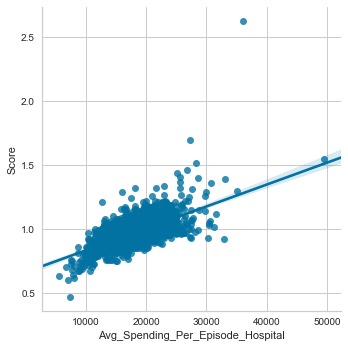

In [9]:
claim_spend= spend_df.merge(claims,on='Provider ID',how= 'left')
print claim_spend.corr()
sns.lmplot('Avg_Spending_Per_Episode_Hospital','Score' , claim_spend)

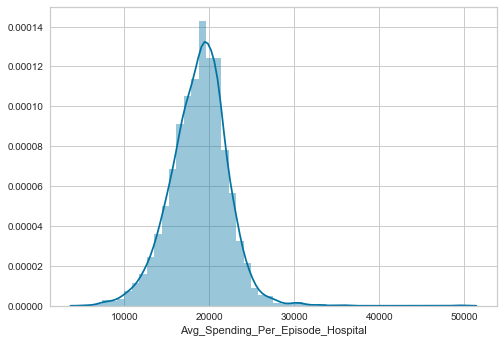

In [10]:
sns.distplot(claims["Avg_Spending_Per_Episode_Hospital"])

In [11]:
claims["Avg_Spending_Per_Episode_Hospital"].var()

11297471.360811945

The Average Spending per Hospital seems to be decently correlated with the inital MSPB scores so I will use this as my target variable

I am going to be taking data from multiple files: 'Hospital General Information, 'HCAHPS', 'Timely and Effective Care', and 'Unplanned Hospital Visits'. Each file has measurements taken by CMS (Centers for Medicare & Medicaid Services) relating to a different aspect of hospital quality. For each file I will isolate the variables I want to select, convert any data that should be floating from string to float (happens a lot in Medicare Data). I will then merge those variables with my dataframe called 'data' which contains my target

#### Handling the Hospital General Information Data

In [12]:
general= pd.read_csv('Hospital General Information.csv')
general.head()


,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Readmission national comparison,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,...,Below the national average,NaN,Below the national average,NaN,Same as the national average,NaN,Same as the national average,NaN,Same as the national average,NaN
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,Above the national average,NaN,Same as the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Below the national average,NaN
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,...,Below the national average,NaN,Below the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Below the national average,NaN
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,Acute Care Hospitals,Voluntary non-profit - Private,...,Below the national average,NaN,Same as the national average,NaN,Below the national average,NaN,Above the national average,NaN,Not Available,Results are not available for this reporting p...
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,Acute Care Hospitals,Proprietary,...,Above the national average,NaN,Not Available,There are too few measures or measure groups r...,Same as the national average,NaN,Above the national average,NaN,Not Available,Results are not available for this reporting p...


In [13]:
general["Proprietary"]= 0
general["Proprietary"].loc[(general['Hospital Ownership'] == "Proprietary")] =1
print general["Proprietary"].value_counts()


0    4006
1     800
Name: Proprietary, dtype: int64


C:\Users\anirudha_nahar\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
general= general.loc[:,["Provider ID","Proprietary"]]
general.head()

,Provider ID,Proprietary
0,10001,0
1,10005,0
2,10006,0
3,10007,0
4,10008,1


In [15]:
data= claims.merge(general ,on='Provider ID', how='left')
data.head()

,Provider ID,Avg_Spending_Per_Episode_Hospital,Proprietary
0,10001,20711,0.0
1,10005,16849,0.0
2,10006,19553,0.0
3,10007,15899,0.0
4,10008,12254,1.0


#### Handling the HCAHPS Data

In [16]:
hcahps= pd.read_csv('HCAHPS - Hospital.csv')
hcahps.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,HCAHPS Measure ID,HCAHPS Question,...,Patient Survey Star Rating Footnote,HCAHPS Answer Percent,HCAHPS Answer Percent Footnote,HCAHPS Linear Mean Value,Number of Completed Surveys,Number of Completed Surveys Footnote,Survey Response Rate Percent,Survey Response Rate Percent Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_STAR_RATING,Summary star rating,...,NaN,Not Applicable,NaN,Not Applicable,1213,NaN,27,NaN,04/01/2015,03/31/2016
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_CLEAN_HSP_A_P,Patients who reported that their room and bath...,...,NaN,65,NaN,Not Applicable,1213,NaN,27,NaN,04/01/2015,03/31/2016
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_CLEAN_HSP_SN_P,Patients who reported that their room and bath...,...,NaN,12,NaN,Not Applicable,1213,NaN,27,NaN,04/01/2015,03/31/2016
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_CLEAN_HSP_U_P,Patients who reported that their room and bath...,...,NaN,23,NaN,Not Applicable,1213,NaN,27,NaN,04/01/2015,03/31/2016
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_CLEAN_LINEAR_SCORE,Cleanliness - linear mean score,...,NaN,Not Applicable,NaN,84,1213,NaN,27,NaN,04/01/2015,03/31/2016


For every dataset that my inputs are contained in, the format is as such: For each hospital there are a variety of scores however rather than have each row being the hospital and the columns being the scores for the various categories, the datasets have a row for each category score pertaining to a hospital. That means each hospital can have numerous rows. I will change each of my variable datasets to a format where each row is a unique hospital and the columns are the scores. 

In [17]:
hcahps_question_df= hcahps[['Provider ID']].drop_duplicates().reset_index(drop=True)
question_list=[row for row in hcahps['HCAHPS Question'].unique()]
mean_question_list= []

for row in question_list:
    if 'linear mean' in row:
        mean_question_list.append(row)
        
for question in mean_question_list:
    question_df= hcahps[hcahps['HCAHPS Question']==question][['HCAHPS Linear Mean Value']]
    question_df=question_df.reset_index(drop=True)
    hcahps_question_df[question]= question_df
    
    
    hcahps_question_df[question]= hcahps_question_df[question].replace("Not Available",np.nan)
 
    hcahps_question_df[question]= pd.to_numeric(hcahps_question_df[question], errors= 'coerce')
    #hcahps_question_df[question]= hcahps_question_df[question].fillna(hcahps_question_df[question].mean())
    
hcahps_question_df.head()

,Provider ID,Cleanliness - linear mean score,Nurse communication - linear mean score,Doctor communication - linear mean score,Staff responsiveness - linear mean score,Pain management - linear mean score,Communication about medicines - linear mean score,Discharge information - linear mean score,Care transition - linear mean score,Overall hospital rating - linear mean score,Quietness - linear mean score,Recommend hospital - linear mean score
0,10001,84.0,90.0,92.0,79.0,86.0,79.0,89.0,82.0,89.0,88.0,89.0
1,10005,83.0,91.0,95.0,84.0,88.0,79.0,88.0,82.0,90.0,87.0,89.0
2,10006,84.0,91.0,94.0,82.0,87.0,75.0,84.0,80.0,85.0,86.0,84.0
3,10007,88.0,91.0,95.0,87.0,90.0,81.0,86.0,83.0,88.0,91.0,86.0
4,10008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
hcahps_question_df.describe()

,Provider ID,Cleanliness - linear mean score,Nurse communication - linear mean score,Doctor communication - linear mean score,Staff responsiveness - linear mean score,Pain management - linear mean score,Communication about medicines - linear mean score,Discharge information - linear mean score,Care transition - linear mean score,Overall hospital rating - linear mean score,Quietness - linear mean score,Recommend hospital - linear mean score
count,4807.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000
mean,268086.708966,87.340480,91.376501,91.873642,85.344768,87.557747,78.826758,87.042310,81.506861,88.803888,83.105203,88.072613
std,156667.873543,3.865093,2.546291,2.424033,4.387970,2.582183,4.292328,3.559123,2.894501,3.248170,5.093613,4.381427
min,10001.000000,70.000000,75.000000,75.000000,63.000000,73.000000,56.000000,66.000000,65.000000,67.000000,59.000000,58.000000
25%,140188.000000,85.000000,90.000000,90.000000,83.000000,86.000000,76.000000,85.000000,80.000000,87.000000,80.000000,86.000000
50%,260034.000000,87.000000,92.000000,92.000000,85.000000,88.000000,79.000000,87.000000,82.000000,89.000000,83.000000,89.000000
75%,390218.000000,90.000000,93.000000,93.000000,88.000000,89.000000,81.000000,89.000000,83.000000,91.000000,87.000000,91.000000
max,670114.000000,99.000000,100.000000,100.000000,99.000000,100.000000,95.000000,99.000000,99.000000,99.000000,98.000000,99.000000


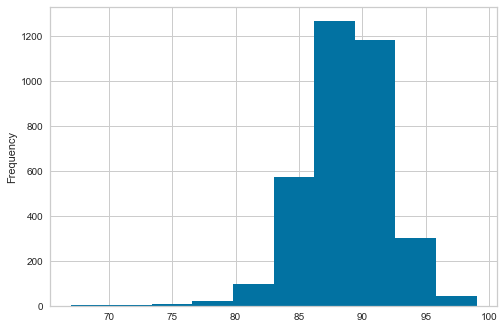

In [19]:
hcahps_question_df["Overall hospital rating - linear mean score"].plot(kind='hist')

In [20]:
#isolating our desired input variable
hcahps_question_df= hcahps_question_df.loc[:,['Provider ID','Overall hospital rating - linear mean score']]
data2= data.merge(hcahps_question_df,on='Provider ID', how='left')
#print data2.isnull().sum()
data2.head()

,Provider ID,Avg_Spending_Per_Episode_Hospital,Proprietary,Overall hospital rating - linear mean score
0,10001,20711,0.0,89.0
1,10005,16849,0.0,90.0
2,10006,19553,0.0,85.0
3,10007,15899,0.0,88.0
4,10008,12254,1.0,NaN


In [21]:
print len(data2)

3152


#### Now to handle the unplanned hospital visits file

In [22]:
readmissions= pd.read_csv('Unplanned Hospital Visits - Hospital.csv')
readmissions.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Compared to National,Denominator,Score,Lower Estimate,Higher Estimate,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Hospital return days for heart attack patients,EDAC_30_AMI,Average,810.0,-5.1,-15.5,6.2,NaN,07/01/2013,06/30/2016
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Hospital return days for heart failure patients,EDAC_30_HF,Average,1052.0,12.3,-1.0,27.0,NaN,07/01/2013,06/30/2016
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Rate of unplanned hospital visits after colono...,OP_32,No Different than the National Rate,255,14.8,10.2,21.0,NaN,01/01/2016,12/31/2016
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Myocardial Infarction (AMI) 30-Day Readm...,READM_30_AMI,No Different than the National Rate,810,16.1,14.2,18.2,NaN,07/01/2013,06/30/2016
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Rate of readmission for CABG,READM_30_CABG,No Different than the National Rate,275,14.3,11.5,17.7,NaN,07/01/2013,06/30/2016


In [23]:
readmission_measure_df= readmissions[['Provider ID']].drop_duplicates().reset_index(drop=True)
question_list=[row for row in readmissions['Measure Name'].unique()]

        
for question in question_list:
    question_df= readmissions[readmissions['Measure Name']==question][['Score']]
    question_df=question_df.reset_index(drop=True)
    readmission_measure_df[question]= question_df
    
    
    readmission_measure_df[question]= readmission_measure_df[question].replace("Not Available",np.nan)
 
    readmission_measure_df[question]= pd.to_numeric(readmission_measure_df[question], errors= 'coerce')
    #readmission_measure_df[question]= readmission_measure_df[question].fillna(readmission_measure_df[question].mean())
    
readmission_measure_df.head()

,Provider ID,Hospital return days for heart attack patients,Hospital return days for heart failure patients,"Rate of unplanned hospital visits after colonoscopy (per 1,000 colonoscopies)",Acute Myocardial Infarction (AMI) 30-Day Readmission Rate,Rate of readmission for CABG,Rate of readmission for chronic obstructive pulmonary disease (COPD) patients,Heart failure (HF) 30-Day Readmission Rate,Rate of readmission after hip/knee replacement,Rate of readmission after discharge from hospital (hospital-wide),Pneumonia (PN) 30-Day Readmission Rate,Rate of readmission for stroke patients
0,10001,-5.1,12.3,14.8,16.1,14.3,19.7,20.9,4.7,15.6,18.5,12.2
1,10005,-22.4,22.0,16.5,15.9,NaN,17.3,23.7,5.6,14.4,15.6,11.8
2,10006,2.6,9.3,19.3,16.8,15.0,19.6,21.6,5.1,15.6,17.8,12.6
3,10007,NaN,9.2,16.3,NaN,NaN,19.7,21.9,5.1,16.6,17.3,12.7
4,10008,NaN,39.3,16.0,NaN,NaN,18.9,22.1,NaN,14.4,16.1,NaN


In [24]:
#isolating our desired input variables
readmssion_to_add= readmission_measure_df.loc[:,["Provider ID","Rate of readmission after discharge from hospital (hospital-wide)","Hospital return days for heart failure patients","Rate of readmission for stroke patients","Pneumonia (PN) 30-Day Readmission Rate","Rate of readmission after hip/knee replacement"]]
data3= data2.merge(readmssion_to_add,on='Provider ID', how='left')
#print data2.isnull().sum()
data3.head()

,Provider ID,Avg_Spending_Per_Episode_Hospital,Proprietary,Overall hospital rating - linear mean score,Rate of readmission after discharge from hospital (hospital-wide),Hospital return days for heart failure patients,Rate of readmission for stroke patients,Pneumonia (PN) 30-Day Readmission Rate,Rate of readmission after hip/knee replacement
0,10001,20711,0.0,89.0,15.6,12.3,12.2,18.5,4.7
1,10005,16849,0.0,90.0,14.4,22.0,11.8,15.6,5.6
2,10006,19553,0.0,85.0,15.6,9.3,12.6,17.8,5.1
3,10007,15899,0.0,88.0,16.6,9.2,12.7,17.3,5.1
4,10008,12254,1.0,NaN,14.4,39.3,NaN,16.1,NaN


In [25]:
print len(data3)

3152


#### Now to handle the timely and effective care file

In [26]:
timeliness= pd.read_csv('Timely and Effective Care - Hospital.csv')
timeliness.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Condition,Measure ID,Measure Name,Score,Sample,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,ED_1b,ED1,276,566,2 - Data submitted were based on a sample of c...,04/01/2016,03/31/2017
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,ED_2b,ED2,94,566,2 - Data submitted were based on a sample of c...,04/01/2016,03/31/2017
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,EDV,Emergency department volume,"High (40,000 - 59,999 patients annually)",NaN,NaN,01/01/2016,12/31/2016
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Preventive Care,IMM_2,Immunization for influenza,92,552,2 - Data submitted were based on a sample of c...,10/01/2016,03/31/2017
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Preventive Care,IMM_3_OP_27_FAC_ADHPCT,Healthcare workers given influenza vaccination,86,4457,NaN,10/01/2016,03/31/2017


In [27]:
#convarting the dataframe so that each row is a unique hospital 
time_measure_df= timeliness[['Provider ID']].drop_duplicates().reset_index(drop=True)

question_list=[row for row in timeliness['Measure ID'].unique()]      

for question in question_list:
    question_df= timeliness[timeliness['Measure ID']==question][['Score']]
    question_df=question_df.reset_index(drop=True)
    question_df= question_df.replace("Not Available",np.nan)
    time_measure_df[question]= question_df
    time_measure_df[question]= pd.to_numeric(time_measure_df[question], errors= 'coerce')
   # time_measure_df[question]= time_measure_df[question].fillna(time_measure_df[question].mean())
time_measure_df= time_measure_df.drop('EDV', axis=1)    
time_measure_df.head(5)

,Provider ID,ED_1b,ED_2b,IMM_2,IMM_3_OP_27_FAC_ADHPCT,OP_1,OP_18b,OP_2,OP_20,OP_21,...,OP_23,OP_29,OP_30,OP_31,OP_33,OP_3b,OP_4,OP_5,PC_01,VTE_6
0,10001,276.0,94.0,92.0,86.0,NaN,176.0,NaN,50.0,93.0,...,NaN,47.0,92.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,10005,244.0,74.0,98.0,80.0,NaN,114.0,NaN,23.0,71.0,...,82.0,79.0,97.0,NaN,100.0,NaN,97.0,13.0,2.0,0.0
2,10006,226.0,68.0,99.0,89.0,NaN,141.0,NaN,12.0,67.0,...,NaN,68.0,83.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,10007,125.0,70.0,99.0,54.0,NaN,118.0,NaN,39.0,72.0,...,46.0,100.0,0.0,100.0,NaN,NaN,100.0,6.0,NaN,NaN
4,10008,200.0,84.0,95.0,53.0,NaN,92.0,NaN,21.0,43.0,...,NaN,62.0,91.0,NaN,NaN,NaN,77.0,5.0,NaN,NaN


In [28]:
#isolating our desired input variable
time_to_add= time_measure_df.loc[:,["Provider ID","ED_2b","IMM_3_OP_27_FAC_ADHPCT","OP_18b"]]
data4= data3.merge(time_to_add,on='Provider ID', how='left')
#print data2.isnull().sum()
data4.head()

,Provider ID,Avg_Spending_Per_Episode_Hospital,Proprietary,Overall hospital rating - linear mean score,Rate of readmission after discharge from hospital (hospital-wide),Hospital return days for heart failure patients,Rate of readmission for stroke patients,Pneumonia (PN) 30-Day Readmission Rate,Rate of readmission after hip/knee replacement,ED_2b,IMM_3_OP_27_FAC_ADHPCT,OP_18b
0,10001,20711,0.0,89.0,15.6,12.3,12.2,18.5,4.7,94.0,86.0,176.0
1,10005,16849,0.0,90.0,14.4,22.0,11.8,15.6,5.6,74.0,80.0,114.0
2,10006,19553,0.0,85.0,15.6,9.3,12.6,17.8,5.1,68.0,89.0,141.0
3,10007,15899,0.0,88.0,16.6,9.2,12.7,17.3,5.1,70.0,54.0,118.0
4,10008,12254,1.0,NaN,14.4,39.3,NaN,16.1,NaN,84.0,53.0,92.0


#### Data Dictionary for our combined dataset

Variable | Description | Type of Variable
---| ---| ---
Proprietary | 0 = Not-For-Profit 1 = For-Profit | categorical
Overall hospital rating-linear mean score | Patient satisfaction with overall hospital | continuous 
Rate of readmission after discharge from hospital (hospital-wide) | Portion of all patients who were readmitted to the hospital after 30 days | continuous 
Hospital return days for heart failure patients | Number of days the patient spent back in the hospital when readmitted due to heart failure | continuous 
Rate of readmission for stroke patients | Portion of patients who were initially hospitalized for stroke that were readmitted in 30 days | continuous 
Pneumonia (PN) 30-Day Readmission Rate | Portion of patients who were initially hospitalized for pneumonia that were readmitted in 30 days | continuous 
Rate of readmission after hip/knee replacement| Portion of patients who were initially hospitalized for hip/knee replacement that were readmitted in 30 days | continuous 
ED_2b | Average (median) time patients spent in the emergency department, after the doctor decided to admit them as an inpatient before leaving the emergency department for their inpatient room| continuous
IMM-3-OP-27-FAC-ADHPCT| Healthcare workers given influenza vaccination| continuous 
OP_18b| Average (median) time patients spent in the emergency department before leaving from the visit| continuous 

Testing for multicoliniarity in the combined dataset 

AxesSubplot(0.125,0.125;0.62x0.755)


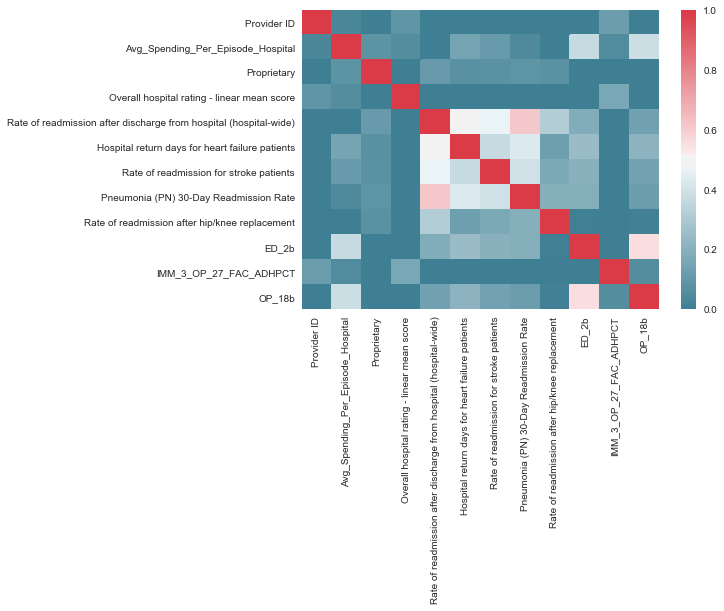

In [29]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
correlations = data4.corr()
#print correlations
print sns.heatmap(correlations, cmap=cmap, vmin=0,vmax=1)

None of the independent variables look too correlated with each other.

In [30]:
#looking to see if there are any missing values now that we have merged everything
data4.isnull().sum()

Provider ID                                                            0
Avg_Spending_Per_Episode_Hospital                                      0
Proprietary                                                            1
Overall hospital rating - linear mean score                          180
Rate of readmission after discharge from hospital (hospital-wide)     19
Hospital return days for heart failure patients                      302
Rate of readmission for stroke patients                              764
Pneumonia (PN) 30-Day Readmission Rate                               228
Rate of readmission after hip/knee replacement                       705
ED_2b                                                                172
IMM_3_OP_27_FAC_ADHPCT                                                 5
OP_18b                                                               195
dtype: int64

In [31]:
#I am only going to work with hospitals with complete information 
data5= data4.dropna(how='any')
print len(data5)

2114


In [32]:
#data5= data5[-480:]
#data5.describe()

Checking for relationships between my independent and dependent variables 

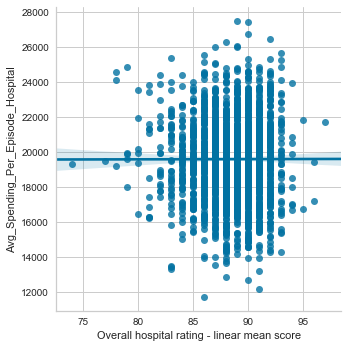

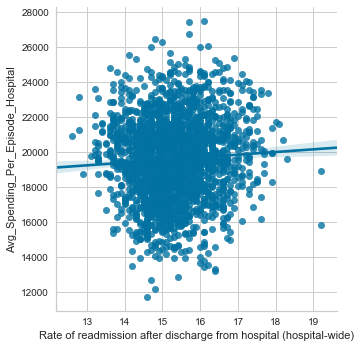

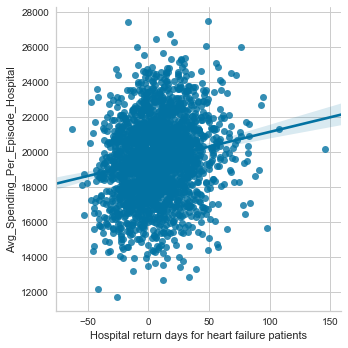

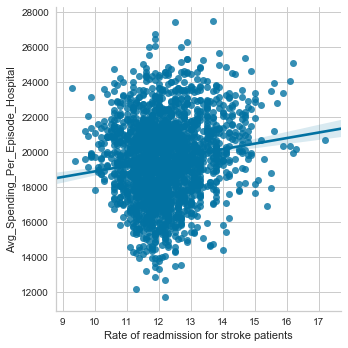

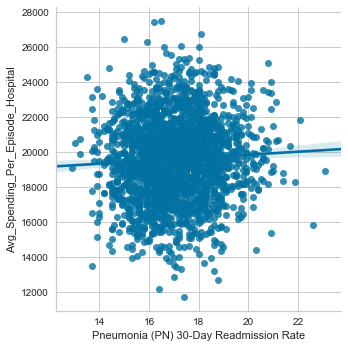

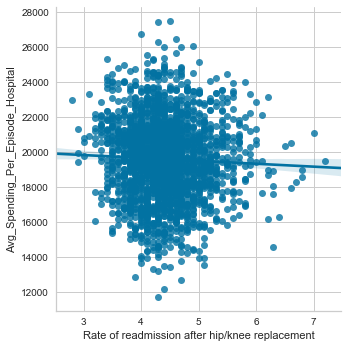

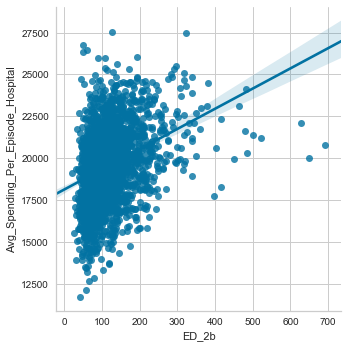

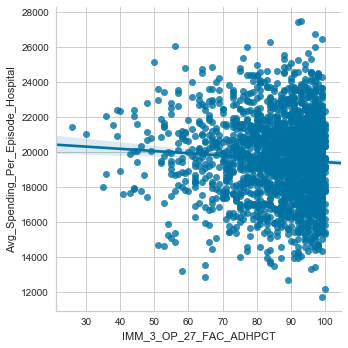

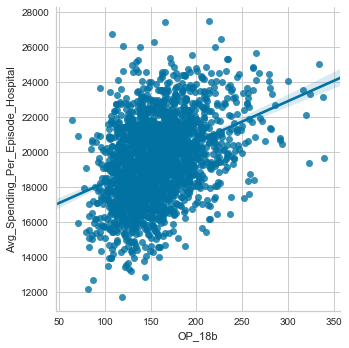

In [33]:
plot_list = ['Overall hospital rating - linear mean score','Rate of readmission after discharge from hospital (hospital-wide)','Hospital return days for heart failure patients','Rate of readmission for stroke patients','Pneumonia (PN) 30-Day Readmission Rate','Rate of readmission after hip/knee replacement','ED_2b','IMM_3_OP_27_FAC_ADHPCT','OP_18b']
for item in plot_list:
    sns.lmplot(item,'Avg_Spending_Per_Episode_Hospital' , data5)

Provider ID                                                         -0.021014
Avg_Spending_Per_Episode_Hospital                                    1.000000
Proprietary                                                          0.027886
Overall hospital rating - linear mean score                          0.001342
Rate of readmission after discharge from hospital (hospital-wide)    0.059071
Hospital return days for heart failure patients                      0.174472
Rate of readmission for stroke patients                              0.138029
Pneumonia (PN) 30-Day Readmission Rate                               0.054111
Rate of readmission after hip/knee replacement                      -0.040768
ED_2b                                                                0.336089
IMM_3_OP_27_FAC_ADHPCT                                              -0.066116
OP_18b                                                               0.372320
Name: Avg_Spending_Per_Episode_Hospital, dtype: float64
AxesSubp

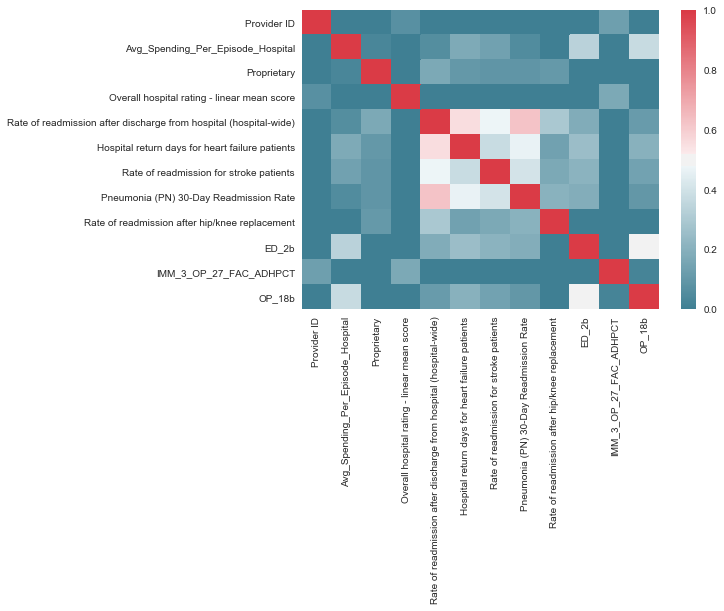

In [34]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
correlations = data5.corr()
print correlations['Avg_Spending_Per_Episode_Hospital']
print sns.heatmap(correlations, cmap=cmap, vmin=0,vmax=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001657BB00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001736B208>]], dtype=object)

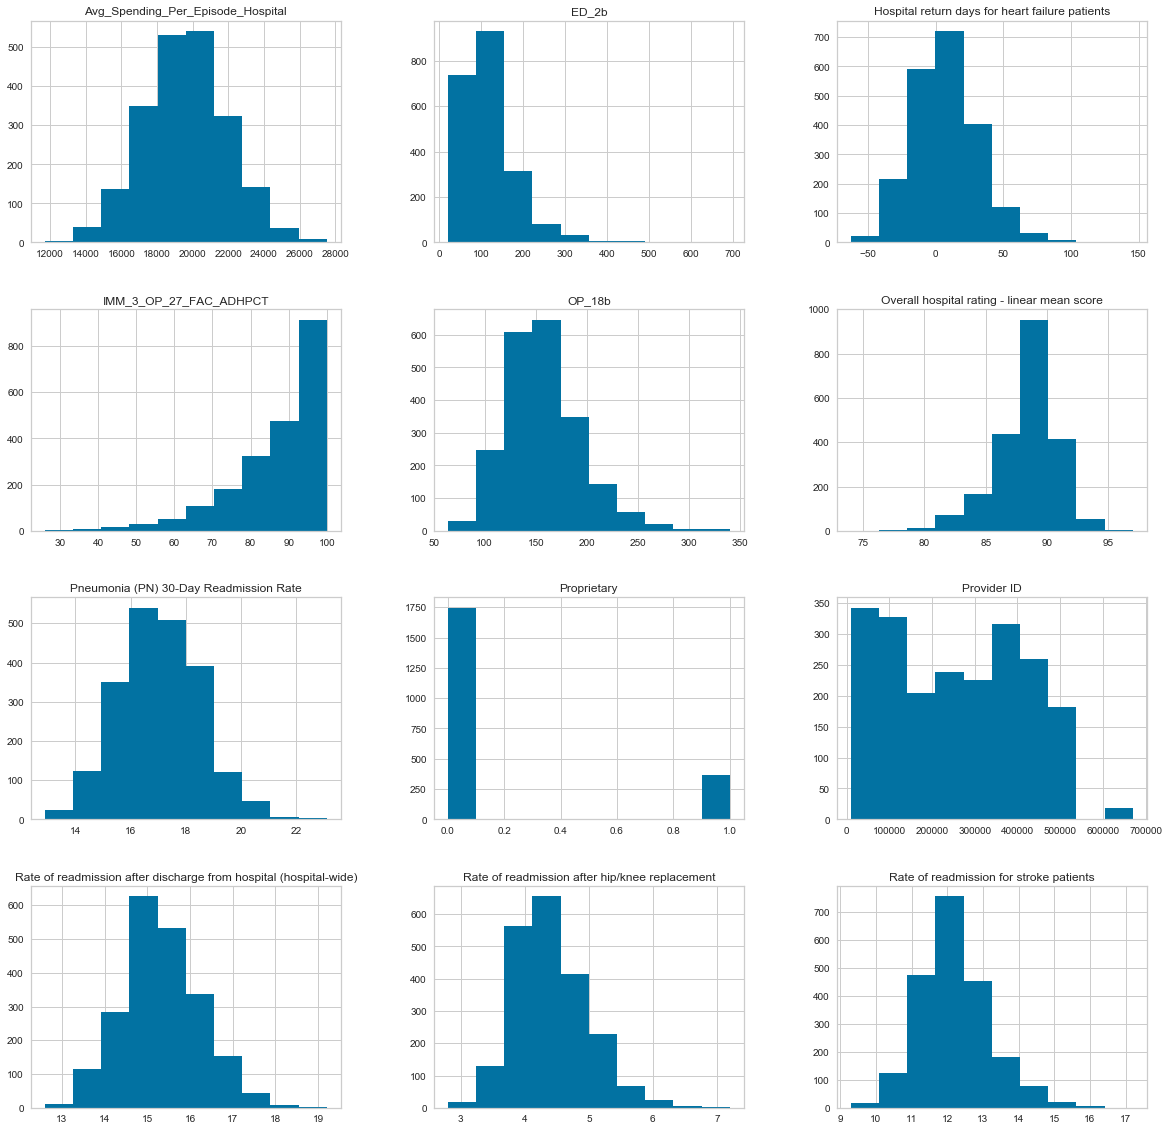

In [35]:
data5.hist(figsize=[20,20])

Looks like there is not too much skew amongst most of the independent variables except "ED_2b" and "IMM_3_OP_27_FAC_ADHPCT". I could log transform these two variables but for now I will not as I care more about interpretation and the rest of the variables seem okay.

## Now I am going to run an OLS

#### First step is to do a train-test split. Going to use 80% test and 20% train

In [36]:

y= pd.DataFrame(data5["Avg_Spending_Per_Episode_Hospital"])
#y= pd.DataFrame(data5["Adj_Spending"])
X= pd.DataFrame(data5.loc[:,["Proprietary",'Overall hospital rating - linear mean score','Rate of readmission after discharge from hospital (hospital-wide)','Hospital return days for heart failure patients','Rate of readmission for stroke patients','Pneumonia (PN) 30-Day Readmission Rate','Rate of readmission after hip/knee replacement','ED_2b','IMM_3_OP_27_FAC_ADHPCT','OP_18b']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
pred = regr.predict(X_test)

# The coefficients
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regr.coef_[0][idx]))
# The mean squared error
print "~~~~~~~~~~~~~~~~~~~~~"
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, pred))


The coefficient for Proprietary is 506.163711433
The coefficient for Overall hospital rating - linear mean score is 83.7778530401
The coefficient for Rate of readmission after discharge from hospital (hospital-wide) is -181.909259461
The coefficient for Hospital return days for heart failure patients is 8.37651256232
The coefficient for Rate of readmission for stroke patients is 204.835422064
The coefficient for Pneumonia (PN) 30-Day Readmission Rate is -43.8228600444
The coefficient for Rate of readmission after hip/knee replacement is -97.2388826779
The coefficient for ED_2b is 7.28800500135
The coefficient for IMM_3_OP_27_FAC_ADHPCT is -8.46363140357
The coefficient for OP_18b is 16.8018016557
~~~~~~~~~~~~~~~~~~~~~
Mean squared error: 4202909.04
Variance score: 0.18


In [37]:
from sklearn import cross_validation
kf = cross_validation.KFold(len(X), n_folds=5, shuffle=True)

C:\Users\anirudha_nahar\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [38]:
from sklearn import metrics
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))
    scores.append(lm.score(X, y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of RMSE for all folds', np.sqrt(np.mean(mse_values))
print 'Mean of R2 for all folds:', np.mean(scores)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 4278313.36063
R2: 0.196575631755
Model 2
MSE: 4080104.01728
R2: 0.196369174994
Model 3
MSE: 4164494.49764
R2: 0.196472963876
Model 4
MSE: 4552725.4952
R2: 0.196233718799
Model 5
MSE: 4610313.7325
R2: 0.196719501371
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 4337190.22065
Mean of RMSE for all folds 2082.59218779
Mean of R2 for all folds: 0.196474198159


The results of this model are far better than the original model where the target was the indexed MSPB score.

Creating the model in statsmodels as well in order to show a better output. Had to change the names of any input variables with spaces as those names were causing issues with statsmodels

In [39]:
data5['HCAHPS_Patient_Rating']= data5.loc[:,'Overall hospital rating - linear mean score']
data5['Discharge_Readmission_Rate']= data5.loc[:,'Rate of readmission after discharge from hospital (hospital-wide)']
data5['Hospital_Return_Days_Heart_Failure']= data5.loc[:,'Hospital return days for heart failure patients']
data5['Readmission__Stroke']= data5.loc[:,'Rate of readmission for stroke patients']
data5['Readmission_Pneumonia']= data5.loc[:,'Pneumonia (PN) 30-Day Readmission Rate']
data5['Readmission_Hip_Knee']= data5.loc[:,'Rate of readmission after hip/knee replacement']
lm_stats = smf.ols(formula="y ~ Proprietary + HCAHPS_Patient_Rating + Discharge_Readmission_Rate + Hospital_Return_Days_Heart_Failure+ Readmission__Stroke+ Readmission_Pneumonia + Readmission_Hip_Knee + ED_2b + IMM_3_OP_27_FAC_ADHPCT + OP_18b", data=data5).fit()
#lm_stats = smf.ols(formula="y ~ X", data=data5).fit()


print lm_stats.summary()
print "~~~~~~~~"
print lm_stats.mse_total

C:\Users\anirudha_nahar\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\anirudha_nahar\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\anirudha_nahar\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     51.71
Date:                Sat, 12 May 2018   Prob (F-statistic):           3.24e-93
Time:                        16:07:32   Log-Likelihood:                -19143.
No. Observations:                2114   AIC:                         3.831e+04
Df Residuals:                    2103   BIC:                         3.837e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

C:\Users\anirudha_nahar\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


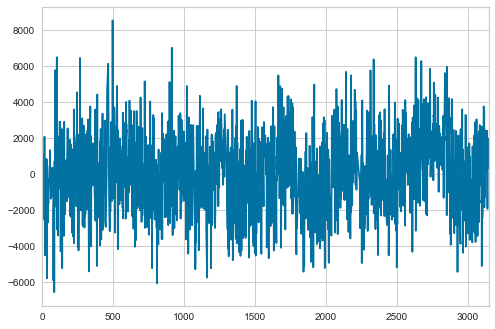

In [40]:
lm_stats.resid.plot()

In [41]:
data5.describe()

,Provider ID,Avg_Spending_Per_Episode_Hospital,Proprietary,Overall hospital rating - linear mean score,Rate of readmission after discharge from hospital (hospital-wide),Hospital return days for heart failure patients,Rate of readmission for stroke patients,Pneumonia (PN) 30-Day Readmission Rate,Rate of readmission after hip/knee replacement,ED_2b,IMM_3_OP_27_FAC_ADHPCT,OP_18b,HCAHPS_Patient_Rating,Discharge_Readmission_Rate,Hospital_Return_Days_Heart_Failure,Readmission__Stroke,Readmission_Pneumonia,Readmission_Hip_Knee
count,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000
mean,261298.895459,19592.338694,0.175024,88.457427,15.314522,7.284579,12.208988,17.046878,4.410028,121.214759,86.985336,157.562914,88.457427,15.314522,7.284579,12.208988,17.046878,4.410028
std,157409.561515,2313.825688,0.380077,2.599162,0.896964,24.022917,1.005628,1.461402,0.569865,64.523249,12.139288,37.065924,2.599162,0.896964,24.022917,1.005628,1.461402,0.569865
min,10001.000000,11718.000000,0.000000,74.000000,12.600000,-62.800000,9.300000,12.900000,2.800000,21.000000,26.000000,64.000000,74.000000,12.600000,-62.800000,9.300000,12.900000,2.800000
25%,110084.000000,18021.000000,0.000000,87.000000,14.700000,-9.000000,11.600000,16.000000,4.000000,78.000000,81.000000,132.000000,87.000000,14.700000,-9.000000,11.600000,16.000000,4.000000
50%,260007.500000,19604.500000,0.000000,89.000000,15.300000,6.000000,12.100000,17.000000,4.400000,107.000000,91.000000,154.000000,89.000000,15.300000,6.000000,12.100000,17.000000,4.400000
75%,390079.750000,21110.250000,0.000000,90.000000,15.900000,21.975000,12.775000,18.000000,4.700000,145.750000,96.000000,178.000000,90.000000,15.900000,21.975000,12.775000,18.000000,4.700000
max,670098.000000,27514.000000,1.000000,97.000000,19.200000,145.600000,17.200000,23.100000,7.200000,692.000000,100.000000,340.000000,97.000000,19.200000,145.600000,17.200000,23.100000,7.200000


In [42]:
print correlations

                                                    Provider ID  \
Provider ID                                            1.000000   
Avg_Spending_Per_Episode_Hospital                     -0.021014   
Proprietary                                           -0.036377   
Overall hospital rating - linear mean score            0.071276   
Rate of readmission after discharge from hospit...    -0.082684   
Hospital return days for heart failure patients       -0.059730   
Rate of readmission for stroke patients               -0.071345   
Pneumonia (PN) 30-Day Readmission Rate                -0.080906   
Rate of readmission after hip/knee replacement        -0.006570   
ED_2b                                                 -0.143031   
IMM_3_OP_27_FAC_ADHPCT                                 0.130726   
OP_18b                                                -0.105276   

                                                    Avg_Spending_Per_Episode_Hospital  \
Provider ID                            

The coefficients for some of the variables do not really make sense here. For example some of the readmission rate variables have negative coefficients which would mean that as readmission rates went up, the efficiency of the hospital went down which does not make much sense. What is happening here is that I put multiple readmission variables to try to increase the accuracy of my model prediction however they were naturally a bit correlated to each other. I originally set a multicoliniarity threshold of 0.75 (meaning I would be concerned if the variables had a correlation of more than 0.75 with each other). Clearly this was too generous. I am now going to remove the hospital wide readmission measure in addition to the Pneumonia Readmission measure since that one was not statistically significant (very high p-value) in the first go-around of running the model. 

After some trial and error I realized that the Hospital Return Days for Heart Failure was the only coefficient I really needed as the other ones barely improved my R-Squared and I would rather have less features than more. 

In [43]:
data5['HCAHPS_Patient_Rating']= data5.loc[:,'Overall hospital rating - linear mean score']
data5['Discharge_Readmission_Rate']= data5.loc[:,'Rate of readmission after discharge from hospital (hospital-wide)']
data5['Hospital_Return_Days_Heart_Failure']= data5.loc[:,'Hospital return days for heart failure patients']
data5['Readmission_Stroke']= data5.loc[:,'Rate of readmission for stroke patients']
data5['Readmission_Pneumonia']= data5.loc[:,'Pneumonia (PN) 30-Day Readmission Rate']
data5['Readmission_Hip_Knee']= data5.loc[:,'Rate of readmission after hip/knee replacement']
lm_stats = smf.ols(formula="y ~ Proprietary + HCAHPS_Patient_Rating + Hospital_Return_Days_Heart_Failure+ ED_2b + IMM_3_OP_27_FAC_ADHPCT + OP_18b", data=data5).fit()
#lm_stats = smf.ols(formula="y ~ X", data=data5).fit()


print lm_stats.summary()
print "~~~~~~~~~~~~~~~~~~~~~"
print lm_stats.mse_total

C:\Users\anirudha_nahar\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\anirudha_nahar\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\anirudha_nahar\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     81.64
Date:                Sat, 12 May 2018   Prob (F-statistic):           4.58e-92
Time:                        16:07:34   Log-Likelihood:                -19155.
No. Observations:                2114   AIC:                         3.832e+04
Df Residuals:                    2107   BIC:                         3.836e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [44]:

y= pd.DataFrame(data5["Avg_Spending_Per_Episode_Hospital"])
#y= pd.DataFrame(data5["Adj_Spending"])
X= pd.DataFrame(data5.loc[:,["Proprietary",'Overall hospital rating - linear mean score','Hospital return days for heart failure patients','ED_2b','IMM_3_OP_27_FAC_ADHPCT','OP_18b']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
pred = regr.predict(X_test)

# The coefficients
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regr.coef_[0][idx]))
# The mean squared error
print "~~~~~~~~~~~~~~~~~~~~~"
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, pred))

The coefficient for Proprietary is 479.629401915
The coefficient for Overall hospital rating - linear mean score is 82.954367273
The coefficient for Hospital return days for heart failure patients is 7.80433790176
The coefficient for ED_2b is 7.32130241885
The coefficient for IMM_3_OP_27_FAC_ADHPCT is -6.77997356097
The coefficient for OP_18b is 16.4480785208
~~~~~~~~~~~~~~~~~~~~~
Mean squared error: 4364736.45
Variance score: 0.21


In [45]:
kf = cross_validation.KFold(len(X), n_folds=5, shuffle=True)

In [46]:
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))
    scores.append(lm.score(X, y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of RMSE for all folds', np.sqrt(np.mean(mse_values))
print 'Mean of R2 for all folds:', np.mean(scores)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 4567138.91127
R2: 0.18705971131
Model 2
MSE: 4489026.22765
R2: 0.187541785138
Model 3
MSE: 4214501.76167
R2: 0.187579955442
Model 4
MSE: 4117304.87051
R2: 0.187940928506
Model 5
MSE: 4592422.30862
R2: 0.187402527154
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 4396078.81594
Mean of RMSE for all folds 2096.68281243
Mean of R2 for all folds: 0.18750498151
